# Presilicon Variability

Demonstration of using Gerabaldi's layered stochastic model and fully-featured device model to degrade circuit parameters at the circuit level affected by multiple underlying mechanisms and show how fabrication process variations impact this degradation.

---------------------------------------------------------------------------------------------------------------------------

Copyright (c) 2023 Ian Hill

SPDX-License-Identifier: Apache-2.0

## 0. Library Installation

In [1]:
pip install gerabaldi

In [2]:
import gerabaldi 
from gerabaldi.models import * 
from gerabaldi.helpers import _on_demand_import

import time as t
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

## 1. Functions Definition

In [3]:
def simulate(save_files: dict = None):
    
    CELSIUS_TO_KELVIN = 273.15
    BOLTZMANN_CONST_EV = 8.617e-5
    SECONDS_PER_HOUR = 3600

    ########################################################################
    ### 1. Define the tests to simulate                                  ###
    ########################################################################
    full_meas = MeasSpec({'amp_gain': NUM_SAMPLES}, {'temp': 30 + CELSIUS_TO_KELVIN, 'vdd': 0.86}, 'Measure All')

    # First is a standard HTOL test
    htol_stress = StrsSpec({'temp': 125 + CELSIUS_TO_KELVIN, 'vdd': 0.92}, 50, 'HTOL Stress')
    htol_test = TestSpec([full_meas], NUM_DEVICES, NUM_LOTS, name='HTOL Similar Test')
    htol_test.append_steps([htol_stress, full_meas], loop_for_duration=1000)

    # Second is a low temperature test
    ltol_stress = StrsSpec({'temp': -10 + CELSIUS_TO_KELVIN, 'vdd': 0.92}, 50, 'Low Temperature Stress')
    ltol_test = TestSpec([full_meas], NUM_DEVICES, NUM_LOTS, name='LTOL Similar Test')
    ltol_test.append_steps([ltol_stress, full_meas], loop_for_duration=1000)

    # Third is a more complex test to showcase the rich test support of the simulator
    ramp_cycle_relax_interval = StrsSpec({'temp': 30 + CELSIUS_TO_KELVIN, 'vdd': 0.86}, 10, 'Ramp Cycle Relax')
    ramp_failure_test = TestSpec([full_meas], NUM_DEVICES, NUM_LOTS, name='Ramp to Failure Test')
    for i in range(10):
        cycle_stress = StrsSpec(
            {'temp': 100 + (10 * i) + CELSIUS_TO_KELVIN, 'vdd': 0.88 + (0.02 * i)}, 90, f"Ramp Cycle Stress {i + 1}")
        ramp_failure_test.append_steps([cycle_stress, full_meas, ramp_cycle_relax_interval, full_meas])

    ########################################################################
    ### 2. Define the test/field environment                             ###
    ########################################################################
    test_env = PhysTestEnv(env_vrtns={
        'temp': EnvVrtnMdl(dev_vrtn_mdl=Normal(0, 0.05), chp_vrtn_mdl=Normal(0, 0.2)),
        'vdd': EnvVrtnMdl(dev_vrtn_mdl=Normal(0, 0.0003), chp_vrtn_mdl=Normal(0, 0.0005))
    })

    ########################################################################
    ### 3. Define the physical device model                              ###
    ########################################################################
    # Model provided in JEDEC's JEP122H as generally used NBTI degradation model, equation 5.3.1
    def bti_vth_shift_empirical(a_0, e_aa, temp, vdd, alpha, time, n):
        return a_0 * np.exp(e_aa / (BOLTZMANN_CONST_EV * temp)) * (vdd ** alpha) * (time ** n)

    # HCI model from Takeda and Suzuki, DOI: https://doi.org/10.1109/EDL.1983.25667
    # Some basic negative temperature dependence term added to enrich the demo
    def hci_vth_shift_empirical(time, vdd, temp, a_0, n, t_0, beta, alpha):
        return a_0 * np.exp(-alpha / vdd) * (t_0 * (temp ** -beta)) * (time ** n)

    # Just use a simple gm*ro gain equation to relate our threshold voltage to an analog circuit parameter
    def v_th_eqn(init, bti, hci, cond):
        v_th = init + bti + hci + cond
        return v_th

    def amp_gain_eqn(v_th, u_n, c_ox, w, l, v_e, vdd): # noqa: AmbiguousVariableName
        v_gs_1 = 0.54 * vdd
        v_gs_2 = 0.69 * vdd
        i_d_1 = 0.5 * (u_n * c_ox * (w / l)) * ((v_gs_1 - v_th) ** 2)
        i_d_2 = 0.5 * (u_n * c_ox * (w / l)) * ((v_gs_2 - v_th) ** 2)

        g_m = (2 * i_d_1) / (v_gs_1 - v_th)
        r_o = (v_e * l) / i_d_2
        return g_m * r_o

    dev_mdl = DeviceMdl({'v_th': DegPrmMdl(
        deg_mech_mdls={
            'bti': DegMechMdl(
                bti_vth_shift_empirical,
                a_0=LatentVar(Normal(0.006, 0.0005)),
                e_aa=LatentVar(Normal(-0.05, 0.0002), chp_vrtn_mdl=Normal(1, 0.0003), lot_vrtn_mdl=Normal(1, 0.0001)),
                alpha=LatentVar(Normal(9.5, 0.002), chp_vrtn_mdl=Normal(1, 0.005)),
                n=LatentVar(Normal(0.4, 0.0005))),
            'hci': DegMechMdl(
                hci_vth_shift_empirical,
                a_0=LatentVar(Normal(0.1, 0.004)),
                n=LatentVar(Normal(0.62, 0.003)),
                alpha=LatentVar(Normal(7.2, 0.03), chp_vrtn_mdl=Normal(1, 0.04)),
                beta=LatentVar(Normal(1.1, 0.002), chp_vrtn_mdl=Normal(1, 0.001), lot_vrtn_mdl=Normal(1, 0.01)),
                t_0=LatentVar(Normal(500, 0.001))
            )},
        init_val_mdl=InitValMdl(init_val=LatentVar(
            Normal(0.42, 0.0001), chp_vrtn_mdl=Normal(0, 0.0002), lot_vrtn_mdl=Normal(0, 0.0003), vrtn_type='offset')),
        compute_eqn=v_th_eqn
    ), 'amp_gain': CircPrmMdl(
        amp_gain_eqn,
        u_n=LatentVar(deter_val=1),
        c_ox=LatentVar(deter_val=1),
        w=LatentVar(deter_val=8),
        l=LatentVar(deter_val=2),
        v_e=LatentVar(deter_val=5)
    )})

    ########################################################################
    ### 4. Simulate the tests                                            ###
    ########################################################################
    test_list = list(DATA_FILES.keys())
    start_time = t.time()
    # First simulate the expected results for the current generation of products
    test_results = {test_list[1]: gerabaldi.simulate(htol_test, dev_mdl, test_env),
                    test_list[2]: gerabaldi.simulate(ltol_test, dev_mdl, test_env),
                    test_list[0]: gerabaldi.simulate(ramp_failure_test, dev_mdl, test_env)}

    # Now simulate for the upcoming process, need to adjust the initial value lot variability and 'alpha' in each model
    dev_mdl.prm_mdl('v_th').init_mdl.latent_var('init_val').lot_vrtn_mdl = Normal(0, 0.0006)
    dev_mdl.prm_mdl('v_th').mech_mdl('bti').latent_var('alpha').chp_vrtn_mdl = Normal(1, 0.01)
    dev_mdl.prm_mdl('v_th').mech_mdl('hci').latent_var('alpha').chp_vrtn_mdl = Normal(1, 0.08)

    test_results[test_list[4]] = gerabaldi.simulate(htol_test, dev_mdl, test_env)
    test_results[test_list[5]] = gerabaldi.simulate(ltol_test, dev_mdl, test_env)
    test_results[test_list[3]] = gerabaldi.simulate(ramp_failure_test, dev_mdl, test_env)
    print(f"Simulation time: {t.time() - start_time} seconds")

    # Save the simulated results to JSON files for reuse if desired
    if save_files:
        for test in test_list:
            test_results[test].export_to_json(save_files[test], 'hours')
    return {test: test_results[test] for test in test_list}


def visualize(rprts):
    
    SECONDS_PER_HOUR = 3600
    
    measured = {}
    for sim in rprts:
        measured[sim] = rprts[sim].measurements

    # Reformat dataframe to get ready for plotting
    for sim in measured:
        measured[sim] = measured[sim].set_index(['param', 'device #', 'chip #', 'lot #'])
        measured[sim] = measured[sim].sort_index()
        measured[sim]['time'] = measured[sim]['time'].apply(
            lambda time, **kwargs: time.total_seconds() / SECONDS_PER_HOUR, axis=1)

    ### 5. Process and visualize results for the user to examine ###
    sb.set_theme(style='ticks', font='Times New Roman')
    sb.set_context('notebook')
    f1, p1 = plt.subplots(figsize=(8, 6))
    f2, p2 = plt.subplots(figsize=(8, 6))

    maxs, mins, avgs, times, final = {}, {}, {}, {}, {}
    for sim in measured:
        maxs[sim] = np.full(len(measured[sim].loc[('amp_gain', 0, 0, 0)]['measured']), -1000)
        mins[sim] = np.full(len(measured[sim].loc[('amp_gain', 0, 0, 0)]['measured']), 1000)
        avgs[sim] = np.zeros(len(measured[sim].loc[('amp_gain', 0, 0, 0)]['measured']))
        times[sim] = measured[sim].loc[('amp_gain', 0, 0, 0)]['time']
        if sim not in ['Current Process: Ramped Cycling', 'New Process: Ramped Cycling']:
            final[sim] = []

    for lot in range(NUM_LOTS):
        for dev in range(NUM_DEVICES):
            for ind in range(NUM_SAMPLES):
                for sim in measured:
                    meas = measured[sim].loc[('amp_gain', ind, dev, lot)].reset_index()['measured']
                    maxs[sim] = np.maximum(maxs[sim], meas)
                    mins[sim] = np.minimum(mins[sim], meas)
                    avgs[sim] += meas
                    if sim not in ['Current Process: Ramped Cycling', 'New Process: Ramped Cycling']:
                        final[sim].append(meas.iloc[-1])

    # Construct the raw degradation over time curves plot
    colour_map = {'Current Process: Ramped Cycling': 'mediumpurple', 'Current Process: HTOL': 'green',
                  'Current Process: LTOL': 'navy', 'New Process: Ramped Cycling': 'plum',
                  'New Process: HTOL': 'lightgreen', 'New Process: LTOL': 'aqua'}
    for sim in measured:
        avgs[sim] /= NUM_SAMPLES * NUM_DEVICES * NUM_LOTS
        p1.plot(times[sim], avgs[sim], color=colour_map[sim], label=sim)
        p1.fill_between(times[sim], mins[sim], maxs[sim], color=colour_map[sim], alpha=0.2)

    p1.axhline(20, color='maroon')
    p1.axhspan(0, 20, color='maroon', alpha=0.05)
    p1.text(625, 19.4, 'Design Failure Criterion', fontsize='small', ha='center', color='maroon')
    p1.set(ylabel='Amplifier Gain', ylim=(14, 30), xlabel='Elapsed Time (hours)', xlim=(0, 1000),
           title='Simulated Expectations and Value Ranges for BTI-HCI Degradation Across Wear-Out Tests')
    p1.grid(alpha=0.2)
    p1.legend(loc='lower left')

    # Construct the final degradation strip plot
    strip = pd.DataFrame(final)
    colour_list = ['green', 'lightgreen', 'navy', 'aqua']
    order_list = ['Current Process: HTOL', 'New Process: HTOL', 'Current Process: LTOL', 'New Process: LTOL']
    sb.set_palette(sb.color_palette(colour_list))
    sb.boxplot(strip, ax=p2, order=order_list, hue_order=order_list, boxprops={'alpha': 0.4}, fliersize=0)
    sb.stripplot(strip, ax=p2, alpha=0.7, order=order_list, hue_order=order_list)
    p2.axhline(20, color='maroon', label='Minimum Functional Gain')
    p2.axhspan(0, 20, color='maroon', alpha=0.05)
    p2.text(2.5, 19.4, 'Design Failure Criterion', fontsize='small', ha='center', color='maroon')

    p2.set(ylabel='Amplifier Gain', ylim=(14, 30),
           title='Simulation of Potential for Wear-Out Test Failures Under BTI-HCI Degradation')
    p2.grid(alpha=0.2)

    sb.despine()
    plt.show()


## 2. Outputs

In [4]:
# Global Variables

DATA_FILES = {'Current Process: Ramped Cycling': 'curr_ramp_report', 'Current Process: HTOL': 'curr_htol_report',
              'Current Process: LTOL': 'curr_ltol_report',
              'New Process: Ramped Cycling': 'next_ramp_report', 'New Process: HTOL': 'next_htol_report',
              'New Process: LTOL': 'next_ltol_report'}

NUM_SAMPLES = 10
NUM_DEVICES = 10
NUM_LOTS = 10

In [5]:
report = simulate()

Simulation time: 447.4704501628876 seconds


### 2.1 Measurements DataFrame 

In [6]:
PROCESS_TO_DISPLAY = list(DATA_FILES.keys())[0] # <- Modify this int for another process
print(f'Displaying DataFrames for "{PROCESS_TO_DISPLAY}"')

Displaying DataFrames for "Current Process: Ramped Cycling"


In [7]:
report[PROCESS_TO_DISPLAY].measurements.head(10)

,param,device #,chip #,lot #,time,measured
0,amp_gain,0,0,0,0 days,29.356625
1,amp_gain,1,0,0,0 days,29.380126
2,amp_gain,2,0,0,0 days,29.508333
3,amp_gain,3,0,0,0 days,29.342934
4,amp_gain,4,0,0,0 days,29.325039
5,amp_gain,5,0,0,0 days,29.390998
6,amp_gain,6,0,0,0 days,29.463106
7,amp_gain,7,0,0,0 days,29.504429
8,amp_gain,8,0,0,0 days,29.424978
9,amp_gain,9,0,0,0 days,29.357814


In [8]:
report[PROCESS_TO_DISPLAY].stress_summary.head(10)

,stress step,duration,start time,end time,temp,vdd
0,Ramp Cycle Stress 1,3 days 18:00:00,0 days 00:00:00,3 days 18:00:00,373.15,0.88
1,Ramp Cycle Relax,0 days 10:00:00,3 days 18:00:00,4 days 04:00:00,303.15,0.86
2,Ramp Cycle Stress 2,3 days 18:00:00,4 days 04:00:00,7 days 22:00:00,383.15,0.90
3,Ramp Cycle Relax,0 days 10:00:00,7 days 22:00:00,8 days 08:00:00,303.15,0.86
4,Ramp Cycle Stress 3,3 days 18:00:00,8 days 08:00:00,12 days 02:00:00,393.15,0.92
5,Ramp Cycle Relax,0 days 10:00:00,12 days 02:00:00,12 days 12:00:00,303.15,0.86
6,Ramp Cycle Stress 4,3 days 18:00:00,12 days 12:00:00,16 days 06:00:00,403.15,0.94
7,Ramp Cycle Relax,0 days 10:00:00,16 days 06:00:00,16 days 16:00:00,303.15,0.86
8,Ramp Cycle Stress 5,3 days 18:00:00,16 days 16:00:00,20 days 10:00:00,413.15,0.96
9,Ramp Cycle Relax,0 days 10:00:00,20 days 10:00:00,20 days 20:00:00,303.15,0.86


### 2.2 Report Visualization 

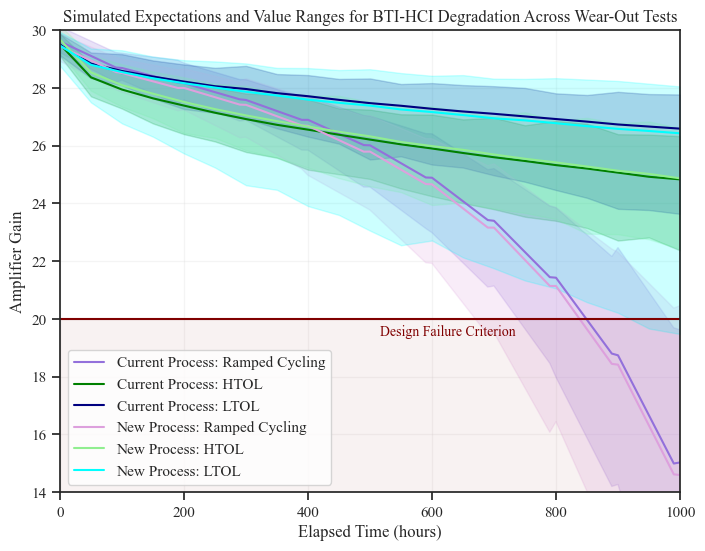

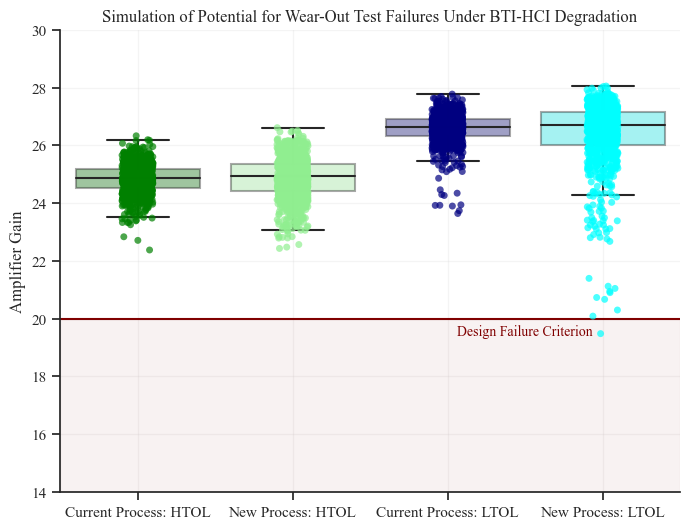

In [9]:
visualize(report)